In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/hj19/anaconda3/envs/spoof/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
import tensorflow as tf

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd

In [4]:
data = pd.read_csv("nasdaq100_padding.csv")


In [5]:

batch_size = 128
timesteps = 20
n_timeseries = data.shape[1]
train_length = 35100
val_length = 2730
test_length = 2730
target = "NDX"

In [6]:
X = np.zeros((len(data), timesteps, data.shape[1]))


In [7]:
for i, name in enumerate(list(data.columns)):
    print(name)
    for j in range(timesteps):
        X[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")

AAL
AAPL
ADBE
ADI
ADP
ADSK
AKAM
ALXN
AMAT
AMGN
AMZN
ATVI
AVGO
BBBY
BIDU
BIIB
CA
CELG
CERN
CMCSA
COST
CSCO
CSX
CTRP
CTSH
DISCA
DISH
DLTR
EA
EBAY
ESRX
EXPE
FAST
FB
FOX
FOXA
GILD
GOOGL
INTC
JD
KHC
LBTYA
LBTYK
LRCX
MAR
MAT
MCHP
MDLZ
MSFT
MU
MXIM
MYL
NCLH
NFLX
NTAP
NVDA
NXPI
PAYX
PCAR
PYPL
QCOM
QVCA
ROST
SBUX
SIRI
STX
SWKS
SYMC
TMUS
TRIP
TSCO
TSLA
TXN
VIAB
VOD
VRTX
WBA
WDC
WFM
XLNX
YHOO
NDX


In [29]:
data.columns

Index(['AAL', 'AAPL', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AKAM', 'ALXN', 'AMAT',
       'AMGN', 'AMZN', 'ATVI', 'AVGO', 'BBBY', 'BIDU', 'BIIB', 'CA', 'CELG',
       'CERN', 'CMCSA', 'COST', 'CSCO', 'CSX', 'CTRP', 'CTSH', 'DISCA', 'DISH',
       'DLTR', 'EA', 'EBAY', 'ESRX', 'EXPE', 'FAST', 'FB', 'FOX', 'FOXA',
       'GILD', 'GOOGL', 'INTC', 'JD', 'KHC', 'LBTYA', 'LBTYK', 'LRCX', 'MAR',
       'MAT', 'MCHP', 'MDLZ', 'MSFT', 'MU', 'MXIM', 'MYL', 'NCLH', 'NFLX',
       'NTAP', 'NVDA', 'NXPI', 'PAYX', 'PCAR', 'PYPL', 'QCOM', 'QVCA', 'ROST',
       'SBUX', 'SIRI', 'STX', 'SWKS', 'SYMC', 'TMUS', 'TRIP', 'TSCO', 'TSLA',
       'TXN', 'VIAB', 'VOD', 'VRTX', 'WBA', 'WDC', 'WFM', 'XLNX', 'YHOO',
       'NDX'],
      dtype='object')

In [38]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
values = data[data.columns].values.reshape(-1,82)
scaled = values.astype('float32')
scaler = MinMaxScaler(feature_range=(-1, 1))
#scaler = StandardScaler()

scaled = scaler.fit_transform(values)
#scaled = (values-(np.min(values)))/(np.max(values)-(np.min(values)))

In [8]:

prediction_horizon = 1
target = data["NDX"].shift(-prediction_horizon).fillna(method="ffill").values

In [9]:
X = X[timesteps:]
target = target[timesteps:]

In [39]:

train,val, test,test1 = scaled[0:train_length,:],scaled[train_length:train_length+val_length,:], scaled[train_length+val_length:,:],scaled[train_length:,]
print(len(train),len(val), len(test),len(test1))

35100 2730 2730 5460


In [40]:
def create_dataset_mul(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [43]:
look_back = 20
X_train, y_train = create_dataset_mul(train, look_back)
X_val, y_val = create_dataset_mul(val, look_back)
X_test, y_test = create_dataset_mul(test, look_back)
#test1X, test1Y = create_dataset_mul(test1, look_back)

35080
2710
2710


In [42]:
X_train = X[:train_length]
X_val = X[train_length:train_length+val_length]
X_test = X[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

In [11]:
X_train.shape

(35100, 20, 82)

In [12]:

X_train_max = X_train.max(axis=0)
X_train_min = X_train.min(axis=0)

X_val_max = X_val.max(axis=0)
X_val_min = X_val.min(axis=0)

X_test_max = X_test.max(axis=0)
X_test_min = X_test.min(axis=0)

target_train_max = target_train.max(axis=0)
target_train_min = target_train.min(axis=0)

In [13]:
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_val = (X_val - X_val_min) / (X_val_max - X_val_min)
X_test = (X_test - X_test_min) / (X_test_max - X_test_min)

y_train = (target_train - target_train_min) / (target_train_max - target_train_min)
y_val = (target_val - target_train_min) / (target_train_max - target_train_min)
y_test = (target_test - target_train_min) / (target_train_max - target_train_min)

In [14]:
X_train=X_train.astype('float32')
X_val=X_val.astype('float32')
X_test=X_test.astype('float32')
y_train=y_train.astype('float32')
y_val=y_val.astype('float32')
y_test=y_test.astype('float32')

In [15]:
X_train=np.array(X_train)
X_val=np.array(X_val)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

In [44]:
first_input = Input(shape=(20,82))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=5, activation='selu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=3, activation='selu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='selu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

ad=add([in0,in1],name='extractor')
#ad=Dropout(0.5)(ad)

#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=5, activation='selu',padding='same')(ad)
#in1= BatchNormalization(scale=False)(in0)
in1=Conv1D(filters=64, kernel_size=3, activation='selu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='selu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

ad1=add([in0,in1],name='extractor1')


#in0=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(ad1)
in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1,'selu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "saved_weights/nasdaq_onestep.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 20, 82)]     0                                            
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 20, 64)       37632       input_10[0][0]                   
__________________________________________________________________________________________________
conv1d_42 (Conv1D)              (None, 20, 64)       20544       lstm_9[0][0]                     
__________________________________________________________________________________________________
conv1d_43 (Conv1D)              (None, 20, 64)       12352       conv1d_42[0][0]                  
____________________________________________________________________________________________

In [45]:
hist = model.fit([X_train],y_train, epochs = 130,validation_data=([X_val],y_val),batch_size=100, verbose = 1,callbacks=[cb])

Train on 35080 samples, validate on 2710 samples
Epoch 1/130
34900/35080 [============================>.] - ETA: 0s - loss: 0.2503
Epoch 00001: val_loss improved from inf to 0.06877, saving model to saved_weights/nasdaq_onestep.hdf5
35080/35080 [==============================] - 8s 238us/sample - loss: 0.2491 - val_loss: 0.0688
Epoch 2/130
34900/35080 [============================>.] - ETA: 0s - loss: 0.0118
Epoch 00002: val_loss did not improve from 0.06877
35080/35080 [==============================] - 7s 187us/sample - loss: 0.0117 - val_loss: 0.0943
Epoch 3/130
34900/35080 [============================>.] - ETA: 0s - loss: 0.0055
Epoch 00003: val_loss improved from 0.06877 to 0.06032, saving model to saved_weights/nasdaq_onestep.hdf5
35080/35080 [==============================] - 7s 188us/sample - loss: 0.0055 - val_loss: 0.0603
Epoch 4/130
34900/35080 [============================>.] - ETA: 0s - loss: 0.0036
Epoch 00004: val_loss improved from 0.06032 to 0.05667, saving model to s

Epoch 33/130
34900/35080 [============================>.] - ETA: 0s - loss: 3.4636e-04
Epoch 00033: val_loss improved from 0.00553 to 0.00484, saving model to saved_weights/nasdaq_onestep.hdf5
35080/35080 [==============================] - 7s 189us/sample - loss: 3.4666e-04 - val_loss: 0.0048
Epoch 34/130
34900/35080 [============================>.] - ETA: 0s - loss: 3.7632e-04
Epoch 00034: val_loss improved from 0.00484 to 0.00402, saving model to saved_weights/nasdaq_onestep.hdf5
35080/35080 [==============================] - 7s 188us/sample - loss: 3.7554e-04 - val_loss: 0.0040
Epoch 35/130
34900/35080 [============================>.] - ETA: 0s - loss: 3.2981e-04
Epoch 00035: val_loss improved from 0.00402 to 0.00372, saving model to saved_weights/nasdaq_onestep.hdf5
35080/35080 [==============================] - 7s 188us/sample - loss: 3.2997e-04 - val_loss: 0.0037
Epoch 36/130
34900/35080 [============================>.] - ETA: 0s - loss: 3.3995e-04
Epoch 00036: val_loss did not i

Epoch 66/130
34900/35080 [============================>.] - ETA: 0s - loss: 2.6050e-04
Epoch 00066: val_loss improved from 0.00180 to 0.00164, saving model to saved_weights/nasdaq_onestep.hdf5
35080/35080 [==============================] - 10s 292us/sample - loss: 2.6023e-04 - val_loss: 0.0016
Epoch 67/130
35000/35080 [============================>.] - ETA: 0s - loss: 2.1914e-04
Epoch 00067: val_loss did not improve from 0.00164
35080/35080 [==============================] - 10s 288us/sample - loss: 2.1896e-04 - val_loss: 0.0035
Epoch 68/130
34900/35080 [============================>.] - ETA: 0s - loss: 2.3860e-04
Epoch 00068: val_loss did not improve from 0.00164
35080/35080 [==============================] - 10s 290us/sample - loss: 2.3815e-04 - val_loss: 0.0042
Epoch 69/130
34800/35080 [============================>.] - ETA: 0s - loss: 2.2652e-04
Epoch 00069: val_loss improved from 0.00164 to 0.00151, saving model to saved_weights/nasdaq_onestep.hdf5
35080/35080 [===================

34900/35080 [============================>.] - ETA: 0s - loss: 2.0144e-04
Epoch 00099: val_loss did not improve from 0.00096
35080/35080 [==============================] - 10s 290us/sample - loss: 2.0144e-04 - val_loss: 0.0015
Epoch 100/130
34900/35080 [============================>.] - ETA: 0s - loss: 2.0526e-04
Epoch 00100: val_loss did not improve from 0.00096
35080/35080 [==============================] - 10s 286us/sample - loss: 2.0530e-04 - val_loss: 0.0053
Epoch 101/130
34800/35080 [============================>.] - ETA: 0s - loss: 2.1031e-04
Epoch 00101: val_loss did not improve from 0.00096
35080/35080 [==============================] - 10s 292us/sample - loss: 2.1026e-04 - val_loss: 0.0011
Epoch 102/130
34900/35080 [============================>.] - ETA: 0s - loss: 2.1787e-04
Epoch 00102: val_loss improved from 0.00096 to 0.00091, saving model to saved_weights/nasdaq_onestep.hdf5
35080/35080 [==============================] - 10s 288us/sample - loss: 2.1760e-04 - val_loss: 9.

In [46]:
model.load_weights('saved_weights/nasdaq_onestep.hdf5')

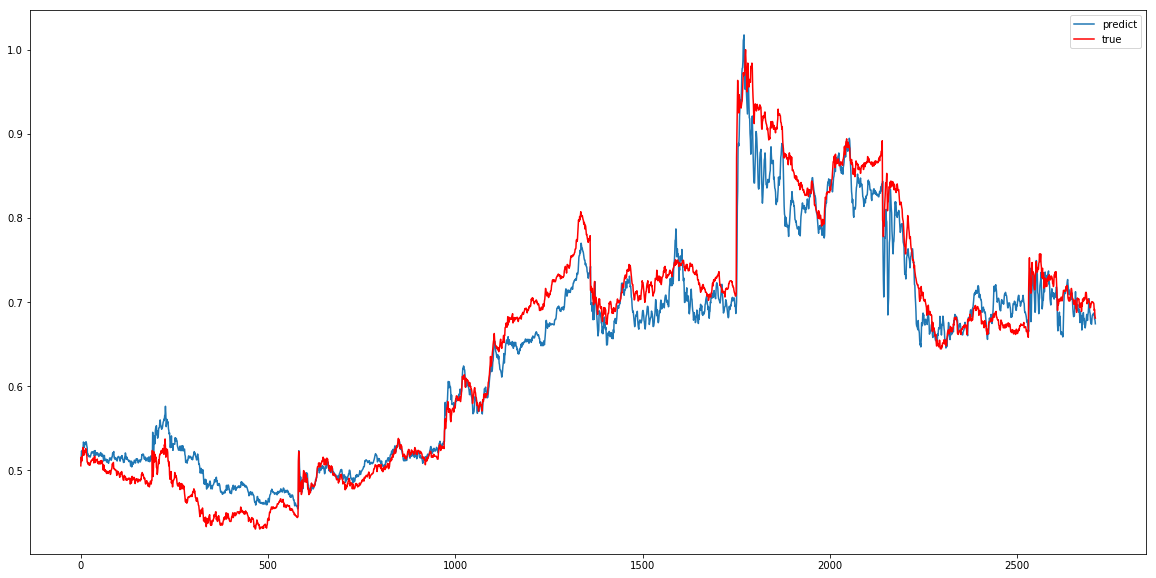

Test RMSE: 0.03014
Test MAE: 0.02372
Test MSE: 0.00091


In [47]:
from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([X_val])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(y_val,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(y_val, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(y_val, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(y_val, yhat)
print('Test MSE: %.5f' % mse)



In [31]:
np.min(y_val)

0.43020773